# One Dimensional Kalman Filter

For our one dimensional system, I will move a cart in simple harmonic motion backwards and forwards.
We want to plot the estimated state, the actual state, and the error, so we need the following libraries:

In [29]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

The state of the cart is $$\mathbf{x}= \begin{bmatrix} x \\ \dot{x} \\ \ddot{x} \end{bmatrix}$$ Where $x$ is the position.

In [30]:
x = np.matrix([[0]] * 3)

We wish to predict $\mathbf{x}$ by measuring $\ddot{x}$, i.e. the acceleration.
A Kalman Filter is a recursive estimator, i.e. it uses a previous value of $\mathbf{x}$ (e.g. $\mathbf{x}_{k-1}$) to calculate a current estimate for $\mathbf{x}$ (e.g. $\mathbf{x}_k$). To do this we use the following equation:
$$\mathbf{x}_k = \mathbf{F}_k \mathbf{x}_{k-1} + \mathbf{B}_k \mathbf{u}_k + \mathbf{w}_k$$
Where $\mathbf{F}$ is the state transition model, which shows how the state evolves given a previous state, and $\mathbf{B}$ is the control-input model, which shows how the system responds when perturbed by an input. $\mathbf{w}_k$ is the process noise, which represents some uncertiantity in the process itself.

In [31]:
GN = 10

In out one-dimensional case, we take
$$\mathbf{F} = \begin{bmatrix} 1 & \Delta t & 0 \\ 0 & 1 & \Delta t \\ 0 & 0 & 1 \end{bmatrix}$$
Where $\Delta t$ is the time step.

In [32]:
DT = 0.001
F = np.matrix([[1, DT, 0], [0, 1, DT], [0, 0, 1]])
t_vals = [x * DT for x in range(0,10000)]

The interpretation of this matrix is just integrating the acceleration to get velocity, and the velocity to get position.
Our control vector is $$\mathbf{u}_k = \begin{bmatrix} 0 \\ 0 \\ a\end{bmatrix}$$
As the system is pertubed by it's acceleration. Since the acceleration is the only thing perturbing the system we can conclude
$$\mathbf{B} = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}$$

In [33]:
B = np.matrix([[0, 0, 0], [0, 0, 0], [0, 0, 1]])

The other half of the Kalman Filter is the measurement step.
$$\mathbf{z}_k = \mathbf{H}_k \mathbf{x}_k + \mathbf{v}_k$$
Where $\mathbf{z}_k$ is a measurement of the system, and $\mathbf{v}_k$ is the observation noise. $\mathbf{H}_k$ is the observation model, which describes how the system influences the measurements. Thus, the matrix $\mathbf{H}^{-1}$ shows how a measurement would affect the state.
In our case, we are measuring acceleration, so we will just let $\mathbf{z}_k = \begin{bmatrix} a \end{bmatrix}$, and thus $\mathbf{H} = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}$

In [34]:
H = np.matrix([[0, 0, 1]])

The process noise has covariance $\mathbf{Q}$, and the observation noise has covariance $\mathbf{R}$. The state, $\mathbf{x}$ also has some estimate of the covariance $\mathbf{P}$

In [35]:
p = np.identity(3) * GN
q = np.identity(3) * GN
r = np.identity(1) * GN

We now want to create matricies to store the historical values, and define some way of calculating $\mathbf{u}_k$

In [36]:
kalman_state = np.empty((len(t_vals), 3))
act_state = np.empty((len(t_vals), 3))

x_old = 0
v_old = 0

OMEGA = 2 * np.pi

def gen_value(i,t):
    global x_old
    global v_old

    x_act = 10 * np.sin(OMEGA * t)

    v_act = (x_act - x_old) / DT
    a_act = (v_act - v_old) / DT

    x_old = x_act
    v_old = v_act

    act_state[i] = np.matrix([x_act, v_act, a_act])

    return (x_act, a_act)

And we finally want to simulate the system. The first half is the prediction stage:
$$\mathbf{\hat{x}}_{k | k-1} = \mathbf{F}_k \mathbf{\hat{x}}_{k-1|k-1} + \mathbf{B}_k \mathbf{u}_l$$
$$\mathbf{P}_{k|k-1} = \mathbf{F}_k \mathbf{P}_{k-1 | k-1} \mathbf{F}^T_k + \mathbf{Q}_k$$
And the second half is the update stage:
$$\mathbf{\tilde{y}}_k  =\mathbf{z}_k - \mathbf{H}_k \mathbf{\hat{x}}_{k|k-1}$$
$$\mathbf{S}_k = \mathbf{H}_k \mathbf{P}_{k|k-1} \mathbf{H}^T_k + \mathbf{R}_k$$
$$\mathbf{K}_k = \mathbf{P}_{k|k-1} \mathbf{H}^T_k \mathbf{S}^{-1}_k$$
$$\mathbf{\hat{x}}_{k|k} = \mathbf{\hat{x}}_{k|k-1} + \mathbf{K}_k \mathbf{\tilde{y}}_k$$
$$\mathbf{P} = (\mathbf{I} - \mathbf{K}_k \mathbf{H}_k)\mathbf{P}_{k|k-1}$$
$$\mathbf{\tilde{y}}_{k|k} = \mathbf{z}_k - \mathbf{H}_k \mathbf{\hat{x}}_{k|k}$$

In [37]:
for (i, t) in enumerate(t_vals):
    (x_act, a_act) = gen_value(i, t)
        
    accel = a_act + float(np.random.normal(0, GN, (1, 1)))
    z = a_act + float(np.random.normal(0, GN, (1, 1)))
       
    u = np.matrix([[0], [0], [accel]])
        
    x_new = F.dot(x) + B.dot(u)
    p_new = F.dot(p).dot(F.T) + q
      
    y = z - H.dot(x_new)

    s = H.dot(p_new).dot(H.T) + r
        
    k = p_new.dot(H.T).dot(s.I)
        
    x_new_new = x_new + k.dot(y)
              
    p_new_new = (np.identity(3) - k.dot(H)).dot(p_new)
        
    y_new = z - H.dot(x_new_new)

    x = x_new_new
    p = p_new_new

    kalman_state[i] = x.T

And we can now plot it

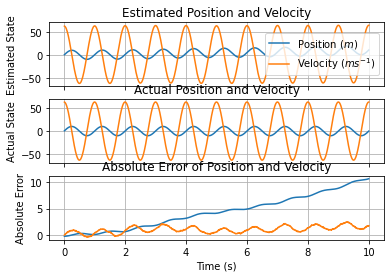

In [38]:
(fig, axes) = plt.subplots(3, sharex=True)

act_state = act_state[10:]
kalman_state = kalman_state[10:]
t_vals = t_vals[10:]

axes[0].plot(t_vals, kalman_state[:, 0], label="Position ($m$)")
axes[0].plot(t_vals, kalman_state[:, 1], label="Velocity ($ms^{-1}$)")
axes[0].grid(True)
axes[0].set_title("Estimated Position and Velocity")
axes[0].set(ylabel = "Estimated State")
axes[0].legend()

axes[1].plot(t_vals, act_state[:, 0])
axes[1].plot(t_vals, act_state[:, 1])
axes[1].grid(True)
axes[1].set_title("Actual Position and Velocity")
axes[1].set(ylabel = "Actual State")

err_vals = kalman_state - act_state

axes[2].plot(t_vals, err_vals[:, 0])
axes[2].plot(t_vals, err_vals[:, 1])
axes[2].grid(True)
axes[2].set_title("Absolute Error of Position and Velocity")
axes[2].set(xlabel = "Time (s)", ylabel = "Absolute Error")

plt.show()